In [1]:
try:
    %load_ext autotime
except:
    %pip install ipython-autotime
    %load_ext autotime

time: 358 µs (started: 2023-10-15 17:40:14 -06:00)


# Approximation Algorithms for Metric TSP

We will study a famous 1.5-factor approximation for metric TSPs due to Nicos Christofides who published it in 1976 and independently by Anatoli Serdyukov (though [the  article is in Russian](http://nas1.math.nsc.ru/aim/journals/us/us17/us17_007.pdf)).

<div class="alert alert-block alert-success">
 Christofides, Nicos (1976), <a href="https://apps.dtic.mil/dtic/tr/fulltext/u2/a025602.pdf"> Worst-case analysis of a new heuristic for the travelling salesman problem</a> , Report 388, Graduate School of Industrial Administration, CMU.
</div>

This remained the best known approximation for metric TSPs until Karlin, Klein and Gharan showed an improved approximation ratio of $1.5 - 10^{-34}$, what they call a "slight improvement". However, new algorithmic techniques often ride on such improvements and are very valuable even if they do not "move the needle" by all that much.

<div class="alert alert-block alert-success">
Anna Karlin, Nathan Klein and Shayan Gharan (2021),  <a href="https://dl.acm.org/doi/10.1145/3406325.3451009"> A (slightly) improved approximation algorithm for metric TSP</a>, Proceedings of the 53rd Annual ACM SIGACT Symposium on Theory of Computing (STOC), ACM Press, pp. 32–45, 2021.
</div>


The basic idea here involves the following four high level steps:
  - We will find a suitable subgraph of the original graph G over which the TSP is defined.
  - We will traverse the subgraph in some manner visiting all its nodes and edges in a systematic manner.
  - We will use a trick called _short-cutting_ to turn our traversal of the subgraph from the previous step into a TSP tour.
  - By choosing the subgraph carefully and relying on the metric TSP properties, we will prove that our TSP tour is within some $\alpha$ factor of the optimal tour.
  
## Metric TSP

Recall that a metric TSP is a TSP defined by a $n \times n$ matrix $C$ of costs such that 
  - It is symmetric: $C_{i,j} = C_{j,i}$
  - It satisfies the triangle inequality: for three distinct  vertices $i, j, k$, we have $C_{i,k} \leq C_{i,j} + C_{j,k}$. I.e, the sum of two sides of a triangle is greater than the third side.


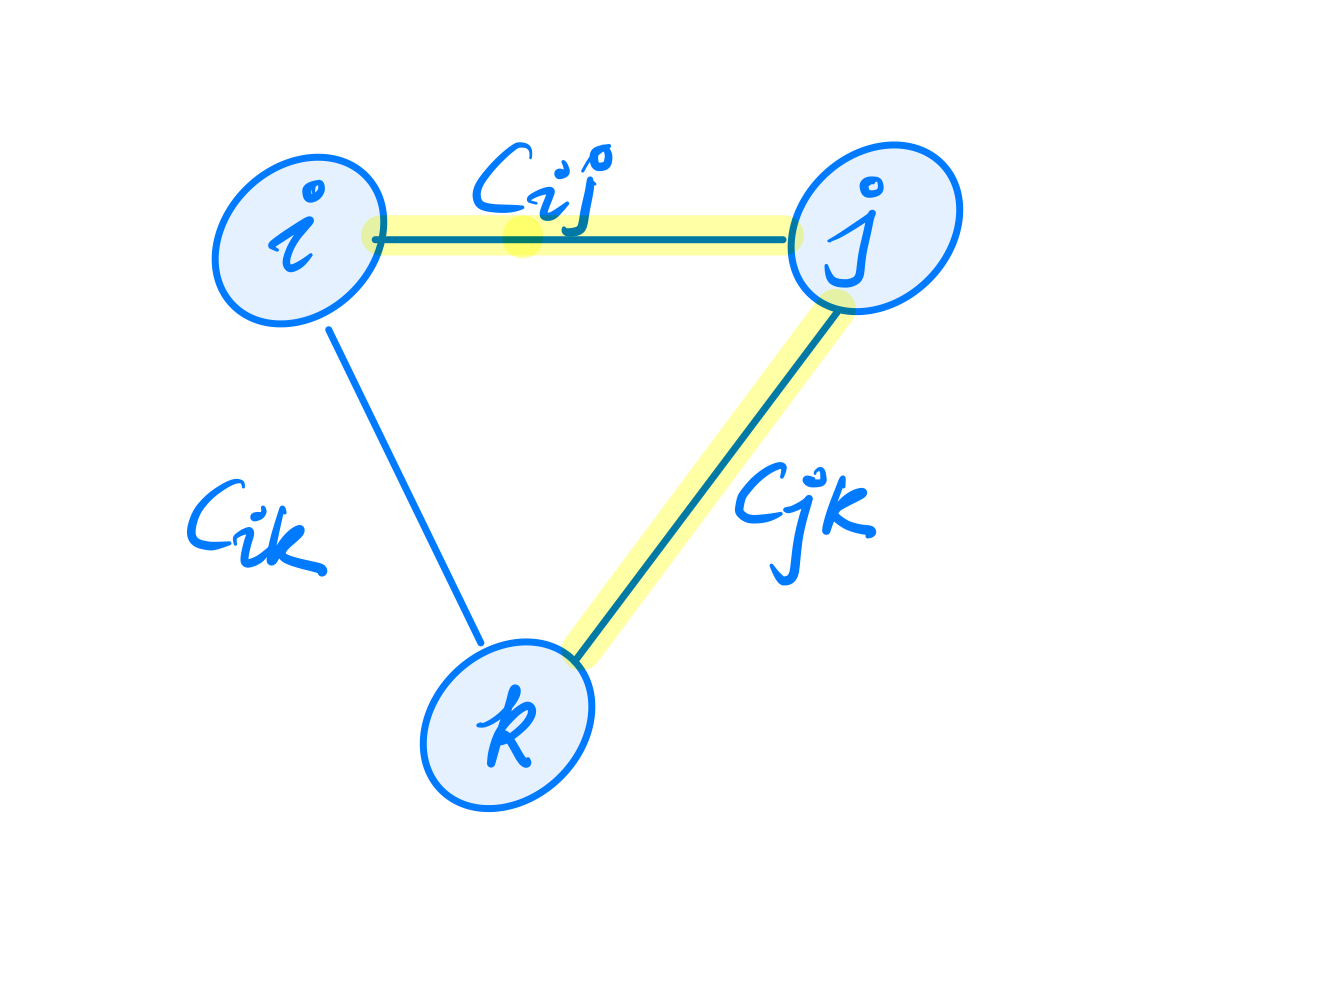</img>
As a convention we will take $C_{i,i} = 0$ for all vertices $i$. Although self-loops do not really matter for a TSP, it makes the subsequent exposition easier.

We note the following very useful property of a metric TSP instance.

<div class="alert alert-block" style="border-color:white black white black">
Consider any walk of length $k \geq 2$ through the graphs: 
    $ i_1 \rightarrow i_2 \rightarrow i_3 \rightarrow \cdots i_k $.
    A <i> walk </i> differs from a path in that we can visit the same vertex repeatedly. In other words, we may have $i_k = i_{\ell}$ in the path for indices $k, \ell$. It follows that
    $$ C_{i_1, i_k} \leq C_{i_1, i_2} + C_{i_2, i_3} + \cdots + C_{i_{k-1}, i_k} \,.$$
 In other words, the "direct edge" between the end points of the path has cost less than or equal to the sum of the costs along the path. This is just the triangle inequality.
</div>

# Minimum Spanning Tree and a 2-Factor Approximation

We will first show a 2-factor approximation using minimum spanning trees.  The concept of a minimum spanning tree was covered in a previous of this sequence on "Trees and Graphs". 

<div class="alert alert-block alert-info">
    A <b> spanning tree </b> of a weighted undirected graph $G$ is a subgraph of $G$ that is a tree (is strongly connected and acyclic). A minimum spanning tree (MST) is one whose sum of edge weights is the smallest amonst all spanning trees.
</div>

Back in our previous course, we talked about the properties of minimum spanning trees and introduced a very efficient algorithm called Kruskal's algorithm that runs in time $O(|E| \log(|E|))$ where $|E|$ is the number of edges of the graph. Here is an illuatration of the MST for some example TSPs.


In [28]:
import networkx as nx
from matplotlib import pyplot as plt

def compute_mst_and_draw(cost_matrix):
    n = len(cost_matrix)
    G = nx.Graph()
    for i in range(n):
        for j in range(i):
            G.add_edge(i, j, weight=cost_matrix[i][j])
    T = nx.minimum_spanning_tree(G, algorithm='kruskal') # networkx has a very convenient implementation of MST for undirected weighted graphs
    pos=nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, style='--')
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edges(T, pos, edge_color="red", style='-', width=2)
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

time: 1.23 ms (started: 2023-10-15 18:20:42 -06:00)


## Example 1

Here is a TSP instance with a given cost matrix

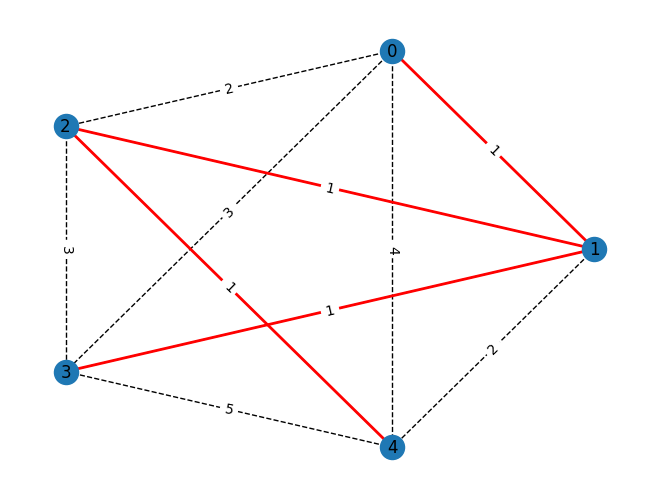

time: 149 ms (started: 2023-10-15 18:20:43 -06:00)


In [29]:
cost_matrix=[
    [0, 1, 2, 3, 4],
    [1, 0, 1, 1, 2],
    [2, 1, 0, 3, 1],
    [3, 1, 3, 4, 5],
    [4, 2, 1, 5, 0]
]
compute_mst_and_draw(cost_matrix)

We have drawn a TSP instance with all the edges and edge weights shown. The edges in the minimum spanning tree are shown in bold red whereas the non-MST edges are shown as dashed lines. Notice that the subgraph defined by the MST is indeed an acyclic graph, it connects every node in the original graph. It is not easy to see directly but it has the smallest weights amongst all such spanning trees.

## Example 2

We demonstrate on a TSP instance with  7 nodes.

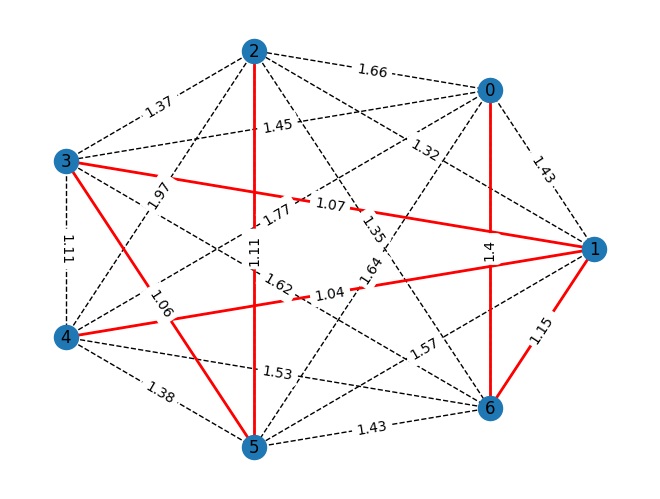

time: 214 ms (started: 2023-10-15 20:16:16 -06:00)


In [35]:
from random import uniform
cost_matrix = [[0 for i in range(7)] for j in range(7)] # create a matrix of dimensions 8 x 8
for i in range(7):
    for j in range(i):
        cost_matrix[i][j] = (int(uniform(1, 2)*100)/100)
        cost_matrix[j][i] = cost_matrix[i][j]
compute_mst_and_draw(cost_matrix)

## Building a TSP Tour from a MST with Shortcutting.

The idea is very simple:
  - Compute a MST for our input graph $G$
  - Start from a fixed starting vertex of the minimum spanning tree $T$ obtained and perform a depth-first traversal of the MST $T$.
  - Whenever the DFS visits a  vertex $v$ for the first time add it to the tour. 
  
 Here is an illustration of this DFS on a MST taken from Example 1 above.
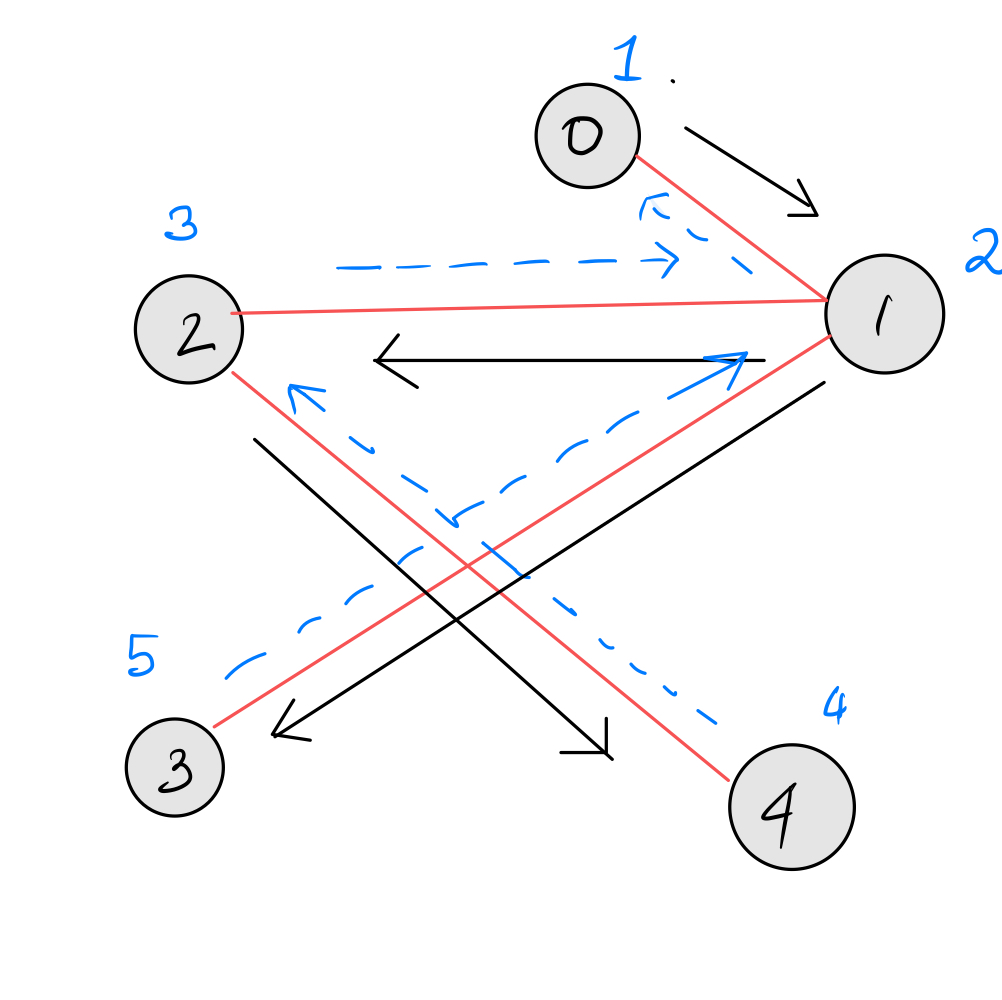</img>

The red edges are those present in the MST. The DFS works as follows:
  - visit 0
  - visit 1
  - visit 2
  - visit 4
  - Backtrack to 2, 1 (shown in dashed blue)
  - visit 3
  - Backtrack to 1, 0 
  
The TSP tour is constructed by taking the order in which the DFS visits nodes:
$$ 0 \rightarrow 1 \rightarrow 2 \rightarrow 4 \color{red}{\leadsto} 3 \color{red}{\leadsto} 0 $$

There are two edges shown in red squiggly arrows: $4 \color{red}{\leadsto} 3$ and $3 \color{red}{\leadsto} 0$. The reason is that these are formed by "shortcutting". In other words, the DFS itself goes from nodes 4 to 3 as follows:
$$4 \color{blue}{\leadsto} 2 \color{blue}{\leadsto} 1 \rightarrow 3$$
the blue squiggly arrows denote that DFS is backtracking. However, the visits to $2,1$ do not count as part of the TSP tour. Instead, the TSP tour we construct directly goes from vertex $4$ straight to the new vertex $3$. This is the essence of "shortcutting": whenver our traversal tries to repeat a vertex we wait until it visits a new previously unseen vertex and add that vertex to the tour.


Here is the code to carry out the construction so far.

In [93]:
import networkx as nx
def tsp_tour_from_mst(cost_matrix, debug=True):
    n = len(cost_matrix)
    assert all(len(cj) == n for cj in cost_matrix), f'cost matrix is not {n}x{n}'
    G = nx.Graph()
    for i in range(n):
        for j in range(i):
            G.add_edge(i, j, weight = cost_matrix[i][j])
    T = nx.minimum_spanning_tree(G, algorithm='kruskal')
    dfs_traversal = nx.dfs_edges(T, source=0) # do a dfs traversal starting from source vertex 0
    l = list(dfs_traversal)
    if debug:
        print('DFS traversal of MST: ')
        print(l)
    tsp_tour = [0] # initialize the tour
    tour_cost = 0
    for (i, j) in l: # go through the edges in the DFS traversal in order
        assert i in tsp_tour # we will have seen the node `i' already in the tour
        if j not in tsp_tour: # have I seen the node j before?
            if debug:
                if i != tsp_tour[-1]: 
                    print(f'\t Shortcutting edge: {(tsp_tour[-1], j)} ')
                else:
                    print(f'\t Tree edge: {(i,j)}')
            tour_cost += cost_matrix[tsp_tour[-1]][j] # add to the cost
            tsp_tour.append(j)# append it to the tour
    if debug:
        print(f'\t Shortcutting edge {(tsp_tour[-1],0)}') 
    tour_cost += cost_matrix[tsp_tour[-1]][0]
    print(f'TSP Tour: {tsp_tour}')
    print(f'Tour Cost: {tour_cost}')
    return (tsp_tour, tour_cost)
        

time: 1.69 ms (started: 2023-10-15 22:05:15 -06:00)


DFS traversal of MST: 
[(0, 1), (1, 2), (2, 4), (1, 3)]
	 Tree edge: (0, 1)
	 Tree edge: (1, 2)
	 Tree edge: (2, 4)
	 Shortcutting edge: (4, 3) 
	 Shortcutting edge (3, 0)
TSP Tour: [0, 1, 2, 4, 3]
Tour Cost: 11


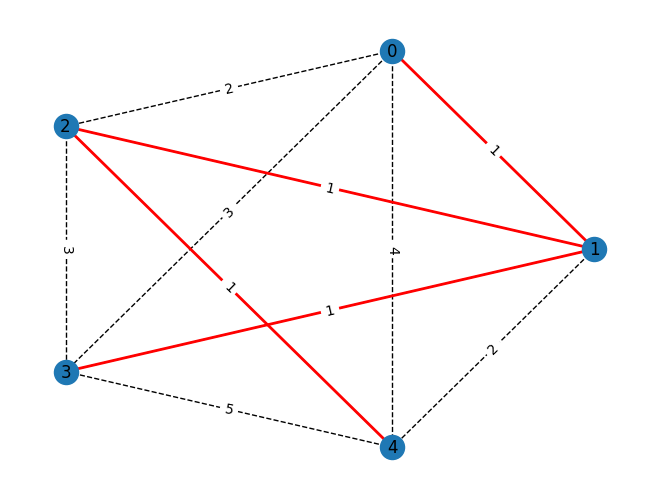

time: 150 ms (started: 2023-10-15 22:05:17 -06:00)


In [94]:
cost_matrix=[
    [0, 1, 2, 3, 4],
    [1, 0, 1, 1, 2],
    [2, 1, 0, 3, 1],
    [3, 1, 3, 4, 5],
    [4, 2, 1, 5, 0]
]
compute_mst_and_draw(cost_matrix)
(tsp_tour, tour_cost) = tsp_tour_from_mst(cost_matrix)

DFS traversal of MST: 
[(0, 6), (6, 4), (4, 2), (4, 5), (6, 1), (0, 3)]
	 Tree edge: (0, 6)
	 Tree edge: (6, 4)
	 Tree edge: (4, 2)
	 Shortcutting edge: (2, 5) 
	 Shortcutting edge: (5, 1) 
	 Shortcutting edge: (1, 3) 
	 Shortcutting edge (3, 0)
TSP Tour: [0, 6, 4, 2, 5, 1, 3]
Tour Cost: 9.61


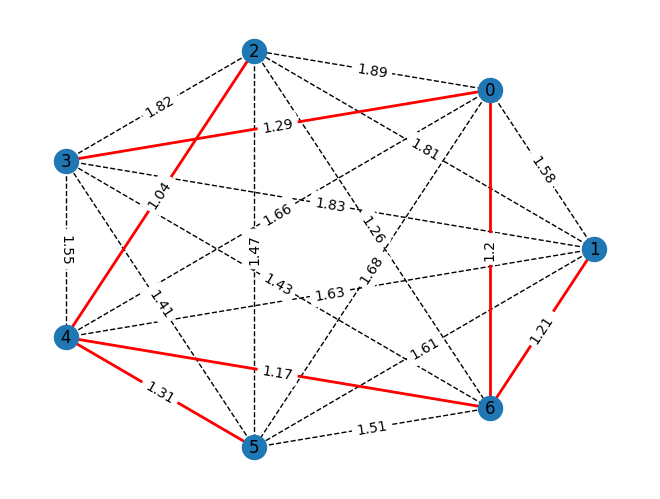

time: 248 ms (started: 2023-10-15 22:05:24 -06:00)


In [95]:
from random import uniform
cost_matrix = [[0 for i in range(7)] for j in range(7)] # create a matrix of dimensions 8 x 8
for i in range(7):
    for j in range(i):
        cost_matrix[i][j] = (int(uniform(1, 2)*100)/100)
        cost_matrix[j][i] = cost_matrix[i][j]
compute_mst_and_draw(cost_matrix)
(tsp_tour, tour_cost) = tsp_tour_from_mst(cost_matrix)

How does the tour constructed from the MST compare with the optimal tour? Turns out that we can prove something about this.

First off, let us look at how our algorithm's tour is constructed. Consider the following facts.
  1. The algorithm does a DFS traversal of the tree. In this traversal, we traverse each edge in the tree twice, once in the forward direction and once while backtracking.
  2. Every edge in the tour is either an edge from the MST or a short cut edge.
  3. Every shortcut edge accounts for a series of "backtrack edges" along the tree and a single MST edge.
  
Therefore, using the metric property of the TSP weights, we note that the cost of each shortcut edge is less than or equal to the sum of the costs of the edges in the MST leading from the source to the destination.

Here is the example again for illustration with the two backtrack edges $(4,3)$ and $(3,0)$ shown.
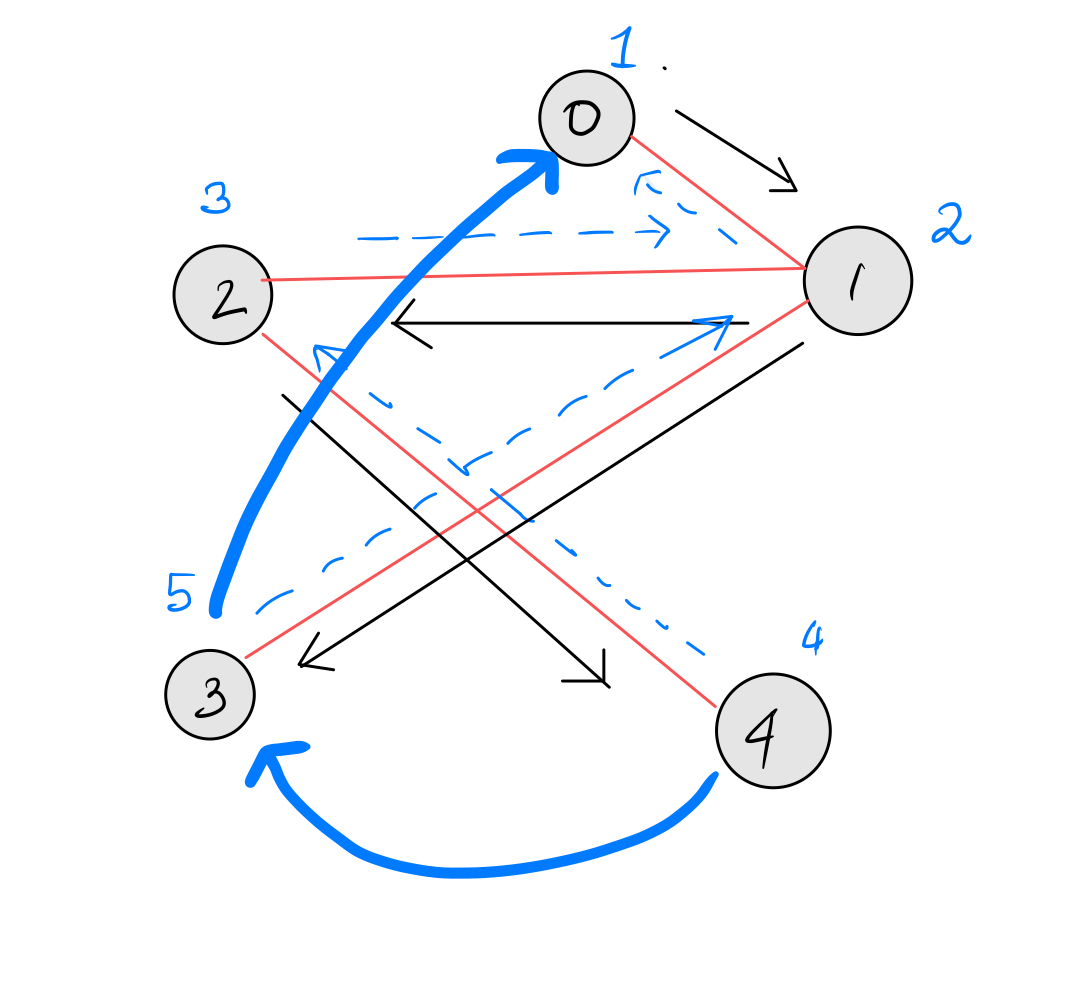

We note that by the metric property  the cost of the edge $(4,3)$ is less than or equal to the cost of the unique  path along the tree that leads from $4$ to $3$.

$$ C_{4,3} \leq C_{4,2} + C_{2,1} + C_{2,3} $$

Similarly, we can conclude

$$C_{3,0} \leq C_{3,1} + C_{1,0} $$

The TSP tour cost is a sum of two costs: (A) cost of all the edges along the spanning tree that form the TSP tour and (B) the cost of all the shortcut edges. Let $\text{cost}(T)$ denote the sum of weight of all edges in the  MST and $\text{cost}(TSP)$ denote the cost of the TSP tour we construct.  Using the metric property, we conclude therefore that 

$$ \text{cost}(TSP) \leq 2 \times \text{cost}(T)$$

In other words, we can account for all the tree edges and short cut edges by traversing each edge in the tree twice (once in forward direction and other while backtracking).

However, consider the optimal tour whose cost is denoted as $\text{OPT}$. In fact, a TSP tour can be taken as a spanning tree if we delete the edge back to the starting point. Therefore, since the minimum spanning tree has the least weight among all spanning trees, we note that 

$$ \text{cost}(T) \leq \text{OPT} $$

This gives us the result we wish by combining the two inequalities above:
$$ \text{cost}(TSP) \leq 2 \times \text{cost}(T) \leq  2 \times\text{OPT}$$

Thus, the TSP tour we have constructed using the MST is a factor-2 approximation to the optimal tour.

**Note:** For subsequent assignments (quizzes, problem sets), we assume intimate knowledge of the material upto this point. We will now present the actual Christofides algorithm that builds on the ideas so far. But involves many graph theoretic concepts that the reader may not be familiar with such as Eulerian tours and minimum cost matching. We hope you will be able to read through and appreciate what we present below but it is not strictly needed. 

## Improving the approximation

We can improve the approximation by improving how we traverse the MST. The idea is as follows: if we just traverse the MST in a depth-first manner, we are forced to add shortcut edges and this costs twice as much as the cost of the MST.

We need to avoid doing a DFS of the MST in the first place. What if we can cleverly add extra edges to the MST up front in a way that these edges are low cost and enable us to traverse the MST in a different way? 

### Eulerian Tours

The key is that instead of doing a depth-first traversal of the MST, we will do an Eulerian tour. What is an Eulerian tour?

<div class="alert alert-block alert-info" style="border-color:black black black black">
    An Eulerian tour of the graph is a traversal that visits every edge exactly once and returns to where we started.
</div>

An Eulerian tour is different from a TSP tour. Whereas a TSP tour insists on visiting every _vertex_ exactly once, an Eulerian tour visits every edge once. It can visit vertices multiple times if needed.

Here are some examples of Eulerian tours.

In [65]:
import networkx as nx
from matplotlib import pyplot as plt 

def construct_eulerian_tour(list_of_edges):
    G = nx.Graph()
    G.add_edges_from(list_of_edges)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightgray')
    plt.show()
    e = nx.eulerian_circuit(G)
    print('Found Eulerian Tour: ')
    first=True
    for (i,j) in e:
        if not first:
            print('->', end='')
        first=False
        print(f' {(i,j)} ', end='')
        

time: 905 µs (started: 2023-10-15 21:13:55 -06:00)


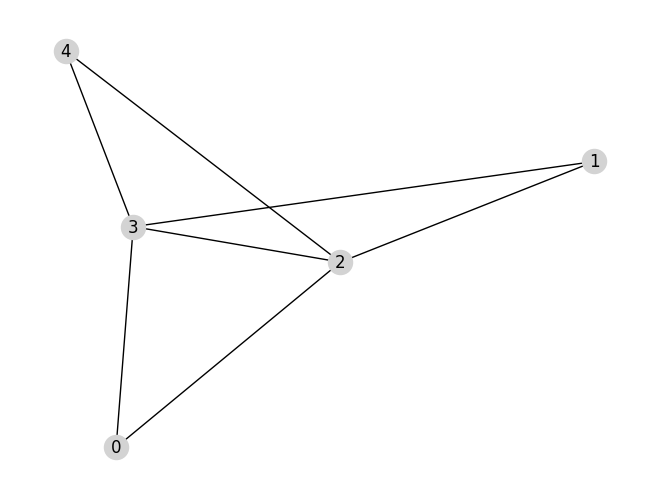

Found Eulerian Tour: 
 (0, 3) -> (3, 4) -> (4, 2) -> (2, 3) -> (3, 1) -> (1, 2) -> (2, 0) time: 115 ms (started: 2023-10-15 21:13:56 -06:00)


In [66]:
construct_eulerian_tour([(0,2), (0,3), (1,2), (1,3), (2,3),(2,4),(3,4)])

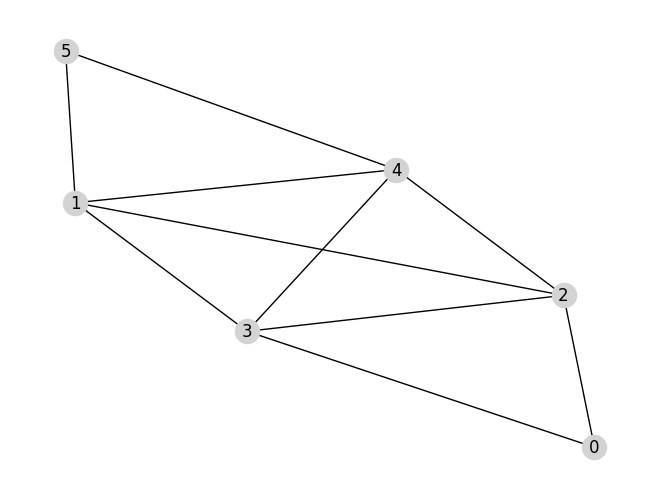

Found Eulerian Tour: 
 (0, 3) -> (3, 4) -> (4, 5) -> (5, 1) -> (1, 4) -> (4, 2) -> (2, 3) -> (3, 1) -> (1, 2) -> (2, 0) time: 102 ms (started: 2023-10-15 21:13:57 -06:00)


In [67]:
construct_eulerian_tour([(0,2), (0,3), (1,2), (1,3), (2,3),(2,4),(3,4), (4,5), (4,1), (5,1)])

We will not present more about Eulerian tours or algorithms for finding them. But it is important to know that not all graphs have Eulerian tours. In fact, a few minutes reflection should convince you that:

<div class="alert alert-block alert-info">
For a graph to have an Eulerian tour, every vertex must have an even number of edges on it. In fact, the converse also holds.
</div>

Why? Note that an Eulerian tour must visit every edge exactly once and return to where we started. In other words, for every vertex that is not the start/end of the tour, if the tour visits the vertex, then it must do so through some edge. It must therefore leave through a different edge. Thus for every edge we need to use to visit a vertex, we need an edge to leave. Therefore, all vertices other than the start/end point must have even degree. The starting point must also have even degree since whenever we leave the starting point, we need to enter through a different edge. Thus, every vertex must have an even number of edges incident on it.

Here is an example where nodes $0,5$ both have odd degrees.

Found Eulerian Tour: 


NetworkXError: G is not Eulerian.

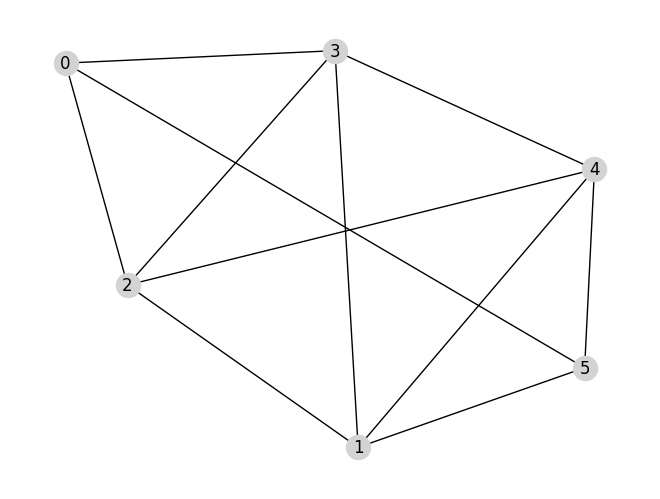

time: 176 ms (started: 2023-10-15 21:13:21 -06:00)


In [64]:
construct_eulerian_tour([(0,2), (0,3), (1,2), (1,3), (2,3),(2,4),(3,4), (4,5), (4,1), (5,1), (5,0)])

## Matching and Minimum Weight Matching

Another useful concept is that of a matching in a graph. Given a graph $G$, a matching in a graph is subset of edges $M$ such that no two edges from $M$ share a vertex. Let us visualize what a matching looks like with a picture:
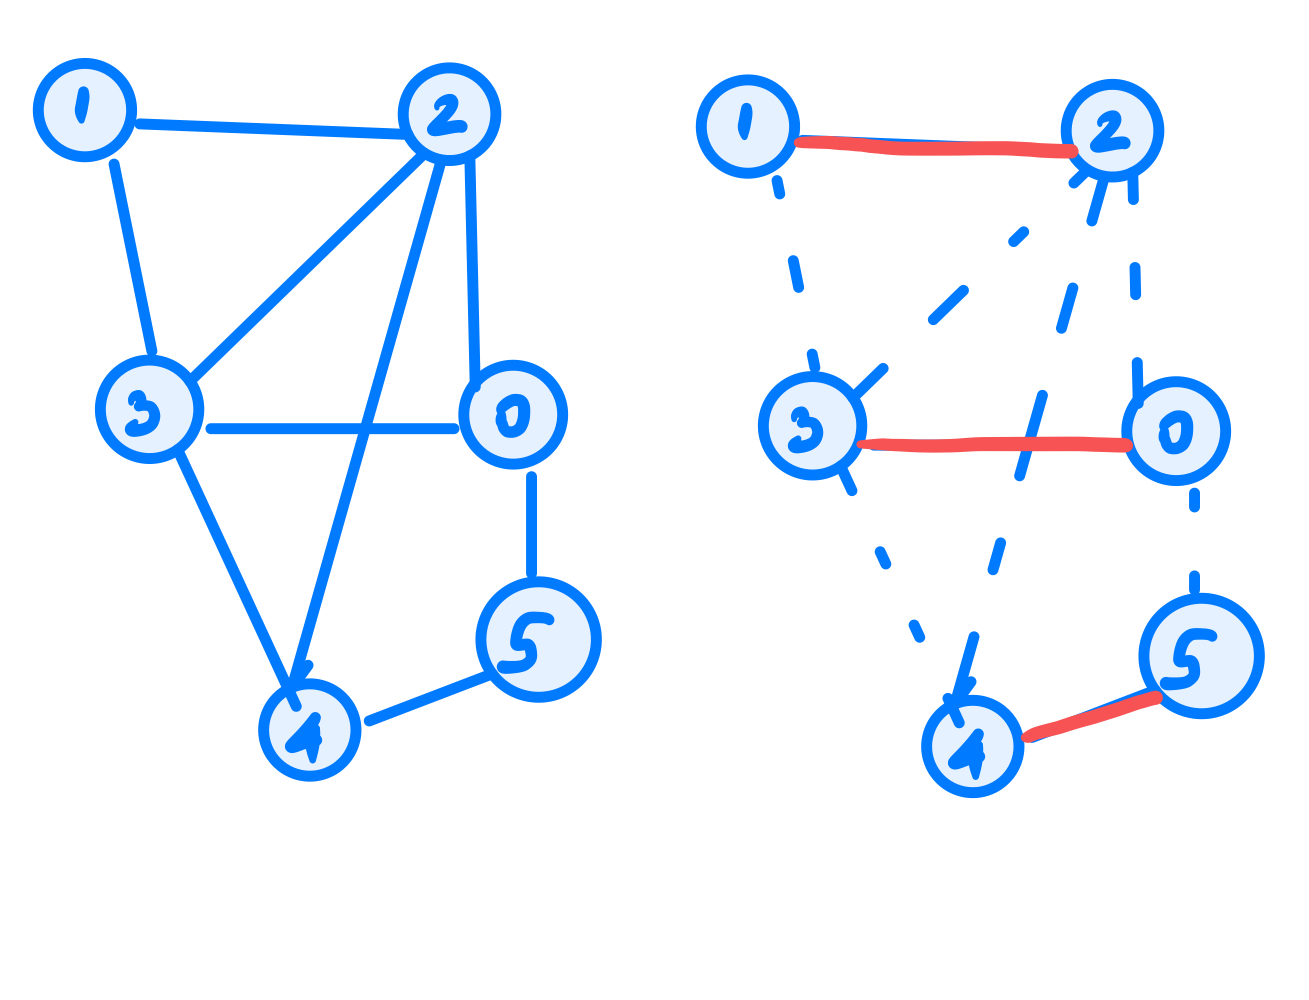

To the left, we have shown a graph and to the right, we show a matching consisting of the edges shown in red. Note that a matching identifies pairs of vertices connected by an edge in the graph so that no two pairs share a common vertex.

Given a complete graph with even number of nodes, there is an efficient algorithm by Edmonds that can compute a minimum weight matching $M$ such that the sum of edge weights of $M$ is minimized over all possible matchings.


## Eulerian Tours of the MST

The problem with the MST is that it is a tree and therefore there are going to be nodes with an odd number of edges on it. You can check the MSTs for the two examples above to note that there are going to be at least two nodes (often more) with odd number of edges.

Going back to Example 1 above note that nodes 0, 1, 3, 4 all have odd degrees in the MST. 

However, we note that the number of such nodes with odd degrees must always be even (there is a very simple proof for this but we will not digress).

The whole idea is as follows:
  - Construct the MST of the original graph $G$.
  - Identify all the odd degree vertices of the MST. There will be an even number of them. 
    - Let $O$ be all the vertices of odd degree.
    - Construct the subgraph of $G$ involving only the vertices in $O$.
    - Compute a minimal cost matching of the subgraph induced by vertices $O$. Let $M$ be the set of edges in the matching.
  - Add the minimal cost matching edges $M$ to the MST edges $T$. This graph is guaranteed to have an even degree for every node.
    - Note that $M$ and $T$ can have edges in common. Therefore combining the edges results in a multi-graph where two nodes can have more than one edges between them.
  - Compute an Eulerian tour of the graph given by the matching and MST edges.
    - Algorithms for constructing Eulerian tours work on multigraphs as well.
  - Shortcut the Eulerian tour to produce a TSP tour.


In [100]:
import networkx as nx

def christofides_tsp_construction(cost_matrix, debug=True):
    #1. Construct a MST
    n = len(cost_matrix)
    assert all(len(cj) == n for cj in cost_matrix), f'cost matrix is not {n}x{n}'
    G = nx.Graph()
    for i in range(n):
        for j in range(i):
            G.add_edge(i, j, weight = cost_matrix[i][j])
    # use networkx to construct MST
    T = nx.minimum_spanning_tree(G, algorithm='kruskal')
    if debug:
        pos=nx.circular_layout(G)
        plt.figure()
        nx.draw(G, pos, with_labels=True, style='--')
        labels = nx.get_edge_attributes(G,'weight')
        nx.draw_networkx_edges(T, pos, edge_color="red", style='-', width=2)
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
        plt.title('Original Graph with Minimum Spanning Tree Edges (red)')
        plt.show()
    #2. Get all odd degree vertices in the MST
    mst_degrees = {i:0 for i in range(n)} # initialize all node degrees to 0
    for (i,j) in T.edges(): #traverse the MST edges one by one
        mst_degrees[i] += 1
        mst_degrees[j] += 1 # increment the degrees of i, j
    odd_degree_nodes = [] # collect all odd degree MST nodes
    for (i, deg) in mst_degrees.items():
        if deg %2 == 1: # if degree is odd 
            odd_degree_nodes.append(i) # add it to odd degree list
    #3. Construct subgraph with odd degree MST nodes
    if debug:
        print(f'Odd degree MST nodes are: {odd_degree_nodes}')
    O = nx.Graph()
    for i in odd_degree_nodes:
        for j in odd_degree_nodes:
            if i < j:
                O.add_edge(i, j, weight=cost_matrix[i][j])
    #4. Compute a matching
    M = nx.min_weight_matching(O)
    if debug:
        print('Min weight matching edges: {', end='')
        for (i,j) in M:
            print(f' {(i,j)} ', end ='')
        print('}')
        plt.figure()
        pos1=nx.circular_layout(O)
        nx.draw(O, pos1, with_labels=True, style='--')
        nx.draw_networkx_edges(O, pos1, edgelist=list(M), edge_color="blue", style='-', width=2)
        labels = nx.get_edge_attributes(O,'weight')
        nx.draw_networkx_edge_labels(O,pos1,edge_labels=labels)
        plt.title('Odd Degree MST nodes subgraph with Minimum Weight Matching')
        plt.show()
    #5. Construct Eulerian Tour
    TplusM = nx.MultiGraph() # we will now construct a multi graph that will involve edges from MST and TSP
    for (i,j) in T.edges(): #add MST edges
        TplusM.add_edge(i, j, weight=cost_matrix[i][j], source='mst')
    for (i,j) in M:
        TplusM.add_edge(i, j, weight=cost_matrix[i][j], source='matching')
    eulerian_circuit = nx.eulerian_circuit(TplusM, source=0)
    tour = [0]
    tour_cost = 0
    # Shortcut the Eulerian tour exactly the same way we shortcut the DFS in the original version
    for (i, j) in eulerian_circuit:
        if j not in tour: # have we seen j before?
            tour_cost = tour_cost + cost_matrix[tour[-1]][j] # update tour cost.
            tour.append(j) #if not add it to the tour
    tour_cost = tour_cost + cost_matrix[tour[-1]][0]
    print(f'Found TSP Tour: {tour}')
    print(f'Tour cost: {tour_cost}')
    return  tour, tour_cost

time: 3.22 ms (started: 2023-10-15 22:17:16 -06:00)


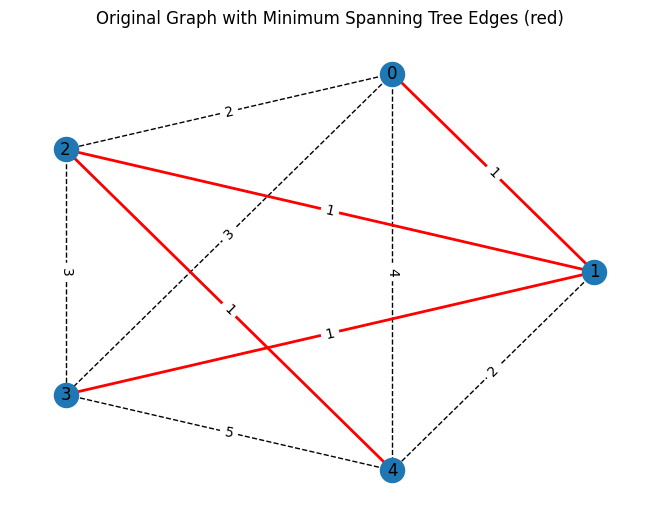

Odd degree MST nodes are: [0, 1, 3, 4]
Min weight matching edges: { (3, 1)  (4, 0) }


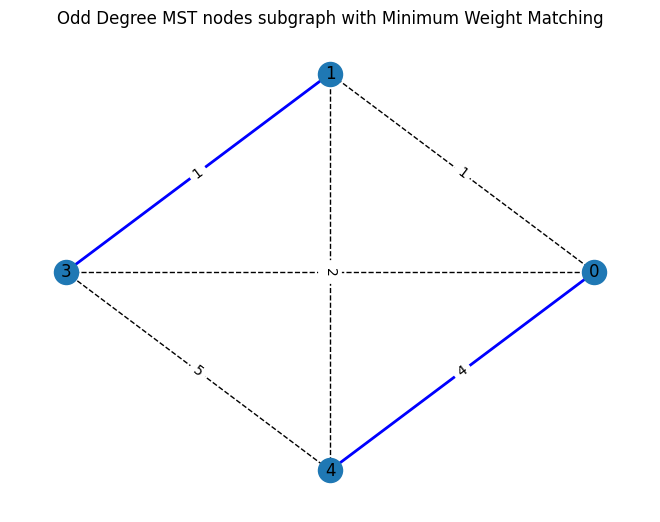

Found TSP Tour: [0, 4, 2, 1, 3]
Tour cost: 10


([0, 4, 2, 1, 3], 10)

time: 272 ms (started: 2023-10-15 22:17:17 -06:00)


In [101]:
cost_matrix=[
    [0, 1, 2, 3, 4],
    [1, 0, 1, 1, 2],
    [2, 1, 0, 3, 1],
    [3, 1, 3, 4, 5],
    [4, 2, 1, 5, 0]
]
christofides_tsp_construction(cost_matrix)

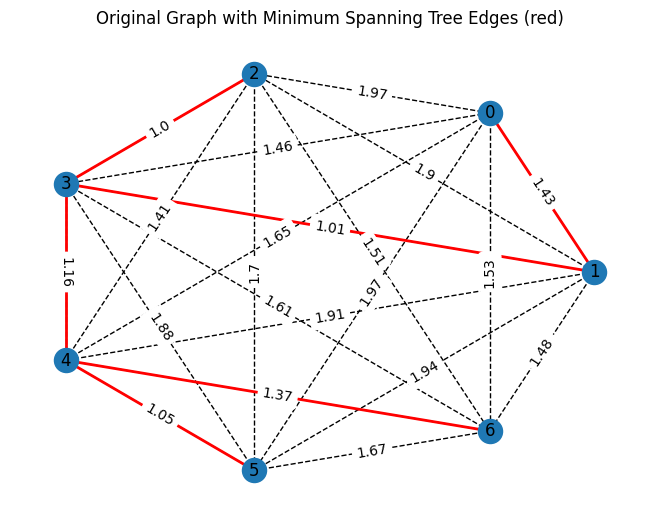

Odd degree MST nodes are: [0, 2, 3, 4, 5, 6]
Min weight matching edges: { (4, 5)  (3, 2)  (0, 6) }


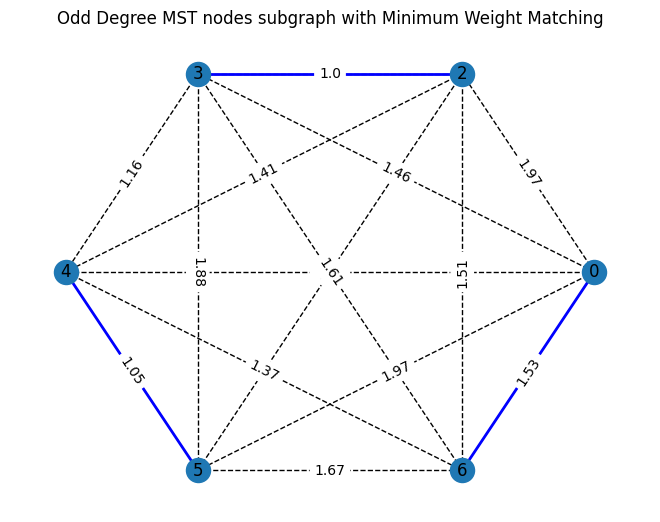

Found TSP Tour: [0, 6, 4, 5, 3, 2, 1]
Tour cost: 10.16
time: 313 ms (started: 2023-10-15 22:17:20 -06:00)


In [102]:
from random import uniform
cost_matrix = [[0 for i in range(7)] for j in range(7)] # create a matrix of dimensions 8 x 8
for i in range(7):
    for j in range(i):
        cost_matrix[i][j] = (int(uniform(1, 2)*100)/100)
        cost_matrix[j][i] = cost_matrix[i][j]
(tsp_tour, tour_cost) = christofides_tsp_construction(cost_matrix)

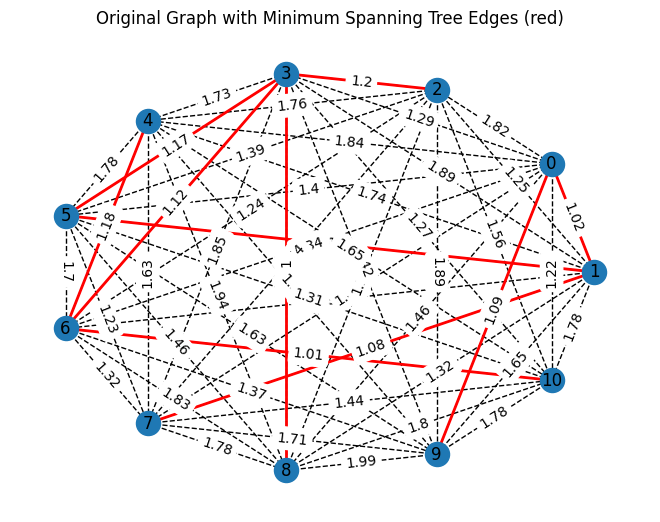

Odd degree MST nodes are: [1, 2, 4, 6, 7, 8, 9, 10]
Min weight matching edges: { (4, 9)  (1, 7)  (10, 6)  (2, 8) }


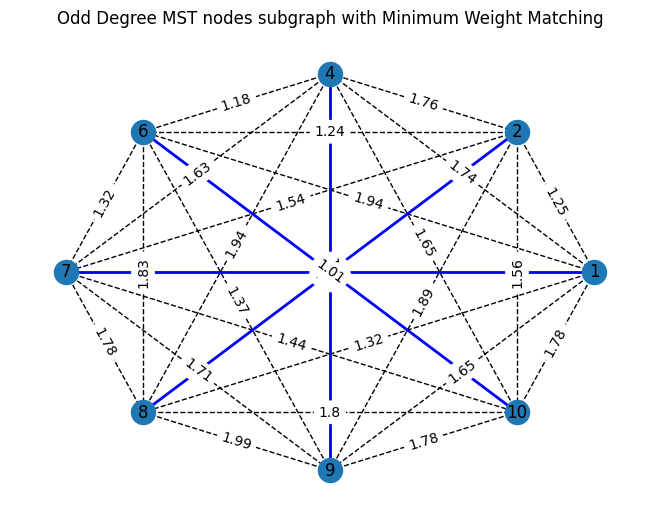

Found TSP Tour: [0, 9, 4, 6, 10, 3, 8, 2, 5, 1, 7]
Tour cost: 13.52
time: 413 ms (started: 2023-10-15 22:17:23 -06:00)


In [103]:
from random import uniform
n = 11
cost_matrix = [[0 for i in range(n)] for j in range(n)] # create a matrix of dimensions 8 x 8
for i in range(n):
    for j in range(i):
        cost_matrix[i][j] = (int(uniform(1, 2)*100)/100)
        cost_matrix[j][i] = cost_matrix[i][j]
(tsp_tour, tour_cost) = christofides_tsp_construction(cost_matrix)

## Analysis of Christofides Algorithm

The key behind the analysis is to note that we are shortcutting an Eulerian tour of the graph built from a combination of MST edges and the matching. Thus, the weight of the TSP tour so obtained must be less than or equal to the sum of all edge weights.

$$ \text{cost}(TSP) \leq \text{cost}(T) + \text{cost}(M) $$

We noted already that the optimal TSP tour of cost $\text{OPT}$ satisfies the inequality $\text{cost}(T) \leq \text{OPT}$.

We will now argue that $\text{cost}(M) \leq \frac{1}{2} \text{cost}(OPT)$. 

Consider the optimal TSP tour. It traverses all vertices in the graph and therefore also traverses vertices in the set $O$ which are all the odd degree vertices. Simply consider the tour as it traverses from one vertex in $O$ to the next shortcutting away all vertices not in $O$. This gives a TSP tour over $O$. The cost of such a tour is less than or equal to the cost of the original TSP tour due to the metric property.

Let $o_1 \rightarrow o_2 \rightarrow \cdots o_k \rightarrow o_1$ be the tour induced over the set $O$. One can see that the tour gives rise to two different matchings $M_1: \{ (o_1, o_2), (o_3, o_4), \ldots, (o_{k-1}, o_k)\}$ or 
$M_2: \{ (o_2, o_3), \ldots, (o_{k}, o_1) \}$. The cost of the optimal tour is thus the sum of the weights of the two matchings.
 $$ \mbox{OPT} = \text{cost}(M_1) + \text{cost}(M_2)$$
 However, $M$ is the minimum weight matching: thus $\text{cost}(M) \leq \text{cost}(M_1), \text{cost}(M) \leq \text{cost}(M_2)$. Combining both, we bet
 $$ 2 \times \text{cost}(M) \leq \text{cost}(M_1) + \text{cost}(M_2) \leq \text{OPT} $$

Therefore, we have 
$$ \text{cost}(TSP) \leq \text{cost}(T) + \text{cost}(M)  \leq \text{OPT} + \frac{1}{2} \text{OPT} = \frac{3}{2} \text{OPT} \,.$$

## That's All Folks!